In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from helper_func import *

# Time Series visualisations

In [2]:
campania = data_by_region('Campania')
campania.tail(7)

,data,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2,incremento_deceduti,incremento_tamponi_molecolari,tasso_positività
8907,23-04-21,Campania,1513,146,1659,90367,92026,8,1970,281092,...,NaN,367674.0,11588.0,3780238.0,367674.0,ITF,ITF3,49,19653.0,0.100239
8928,24-04-21,Campania,1499,140,1639,90223,91862,-164,2012,283223,...,NaN,369686.0,11588.0,3801889.0,369686.0,ITF,ITF3,45,21651.0,0.092929
8949,25-04-21,Campania,1511,137,1648,90683,92331,469,1854,284587,...,NaN,371540.0,11588.0,3819297.0,371540.0,ITF,ITF3,21,17408.0,0.106503
8970,26-04-21,Campania,1527,141,1668,90051,91719,-612,1282,286423,...,NaN,372822.0,11588.0,3830661.0,372822.0,ITF,ITF3,58,11364.0,0.112812
8991,27-04-21,Campania,1506,136,1642,90037,91679,-40,1654,288080,...,NaN,374476.0,11588.0,3848696.0,374476.0,ITF,ITF3,37,18035.0,0.091711
9012,28-04-21,Campania,1507,136,1643,90160,91803,124,1844,289769,...,NaN,376320.0,11588.0,3871700.0,376590.0,ITF,ITF3,31,23004.0,0.080160
9033,29-04-21,Campania,1462,137,1599,90286,91885,82,1986,291640,...,NaN,378306.0,11588.0,3893643.0,380460.0,ITF,ITF3,33,21943.0,0.090507


In [3]:
# on 12/06/20 there was a recalculation for the Campania Region
# -229 (registered value) = -230 (recalculation) + 1 (new infection on 12/06)
# https://www.salernotoday.it/cronaca/coronavirus-campania-ricalcolo-contagi-12-giugno-2020.html
campania.loc[campania['nuovi_positivi']<0, 'nuovi_positivi'] = 1

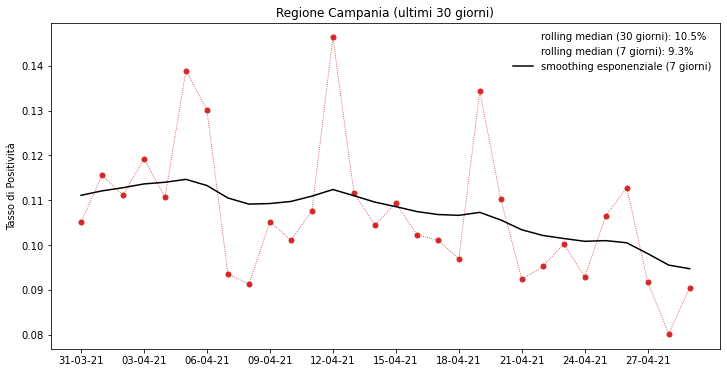

In [4]:
plot_smooth(campania, type='positività', time_window=30, smooth_window=7, save=False)

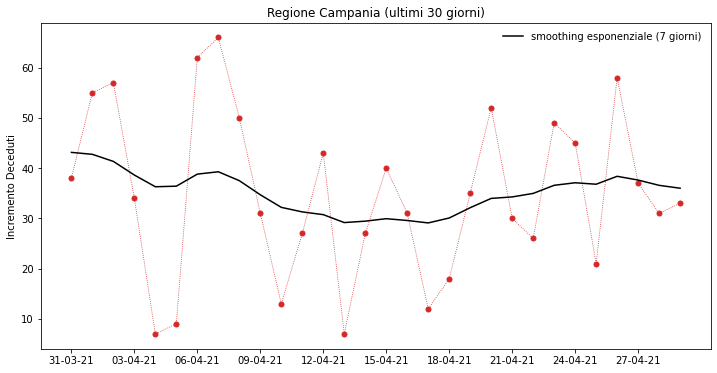

In [5]:
plot_smooth(campania, 'deceduti', 30)

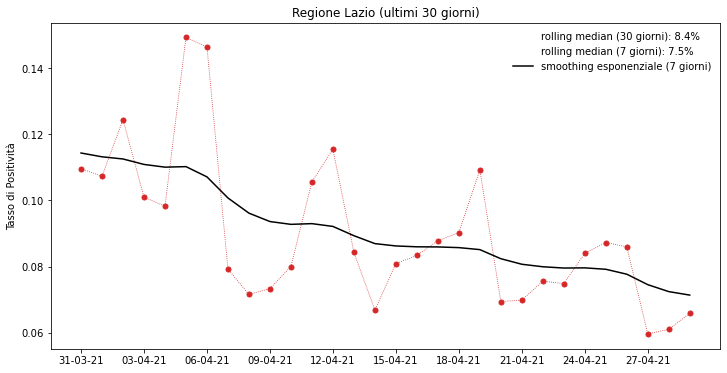

In [6]:
reg = data_by_region('lazio')
plot_smooth(reg, 'positività', time_window=30)

# Deep Learning forecast

In [7]:
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [8]:
train = campania.nuovi_positivi.values
sc = MinMaxScaler(feature_range = (0, 1))
train_sc = sc.fit_transform(train.reshape(-1, 1))

In [9]:
X, y = [], []
for i in range(1, len(campania)):
    X.append(train_sc[i-1:i, 0])
    y.append(train_sc[i, 0])

X, y = np.asarray(X), np.asarray(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape, y.shape

((430, 1, 1), (430,))

## LSTM layers

In [10]:
# Input
inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))

# 1st hidden layer
x = keras.layers.LSTM(60, return_sequences=True)(inputs)
x = keras.layers.Dropout(0.25)(x, training=True)

# 2nd hidden layer
x = keras.layers.LSTM(50)(x)
x = keras.layers.Dropout(0.25)(x, training=True)

# Output
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='best_lstm_model.hdf5',
                                                            save_best_only=True, monitor='val_loss',
                                                            mode='auto', verbose=1)


#model.summary()

In [11]:
history = model.fit(X, y, epochs = 100, batch_size = 16, validation_split = 0.15, shuffle=False,
                    callbacks=[early_stopping_monitor, model_checkpoint_callback])

Epoch 1/100
23/23 [==============================] - 9s 135ms/step - loss: 0.0240 - val_loss: 0.1748

Epoch 00001: val_loss improved from inf to 0.17480, saving model to best_lstm_model.hdf5
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.1288

Epoch 00002: val_loss improved from 0.17480 to 0.12878, saving model to best_lstm_model.hdf5
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0907

Epoch 00003: val_loss improved from 0.12878 to 0.09068, saving model to best_lstm_model.hdf5
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0236 - val_loss: 0.0687

Epoch 00004: val_loss improved from 0.09068 to 0.06869, saving model to best_lstm_model.hdf5
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0250 - val_loss: 0.0524

Epoch 00005: val_loss improved from 0.06869 to 0.05237, saving model to best_lstm_model.hdf5
Epoch 6/100
23/23 [==================

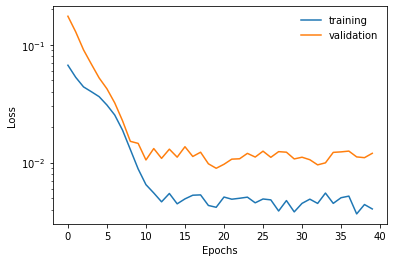

In [12]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.yscale('log', base=10)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [13]:
predict = model.predict(X)
predict = sc.inverse_transform(predict)

predicted = []
for i in predict:
    predicted.append(i[0])

In [14]:
predicted_df = campania[1:][['data']]
predicted_df['predizioni'] = predicted
predicted_df['dati DPC'] = campania.nuovi_positivi
predicted_df[-30:].describe()

,predizioni,dati DPC
count,30.000000,30.000000
mean,1762.663180,1820.700000
std,451.275916,378.289449
min,712.685486,846.000000
25%,1589.388947,1665.500000
50%,1781.453674,1910.000000
75%,2028.911499,2046.750000
max,2499.569092,2314.000000


In [15]:
residuals = predicted_df['predizioni'] - predicted_df['dati DPC']
residuals.median()

50.917959213256836

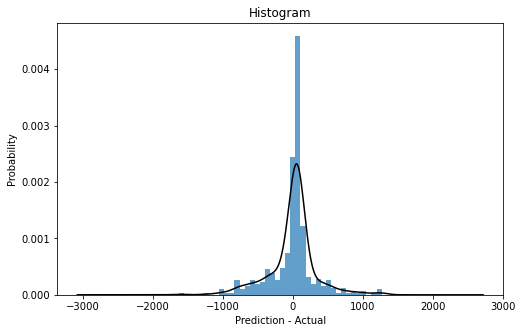

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
residuals.plot.hist(ax=ax, density=True, bins=40, color='tab:blue', alpha=0.7)
residuals.plot.kde(ax=ax, legend=False, title='Histogram', c='k')
ax.set_ylabel('Probability')
ax.set_xlabel('Prediction - Actual');

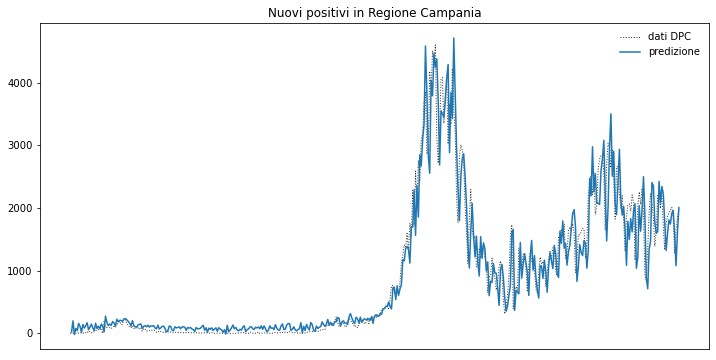

In [17]:
plt.figure(figsize=(12,6))
plt.plot(campania.data, campania.nuovi_positivi, 'k', ls=':', lw=1, alpha=0.8, label='dati DPC')
plt.plot(predicted_df.data, predicted_df.predizioni, 'tab:blue', label='predizione')
plt.xticks([])

plt.legend(frameon=False)
plt.title('Nuovi positivi in Regione Campania')
#plt.savefig('LSTM_fit.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## LSTM – prediction for tomorrow
### Confidence interval estimated from $N\gg1$ predicts (*if* training=True in best_lstm_model)

In [18]:
# Confidence Level and number of iterations (better not to go below 1000)
cl = 0.9
N = 2000

In [19]:
last = campania.nuovi_positivi.values[-1]
last_sc = sc.transform(last.reshape(-1, 1))
X_tomorrow = np.reshape(last_sc, (last_sc.shape[0], last_sc.shape[1], 1))

Computing: [##################################################] 100%


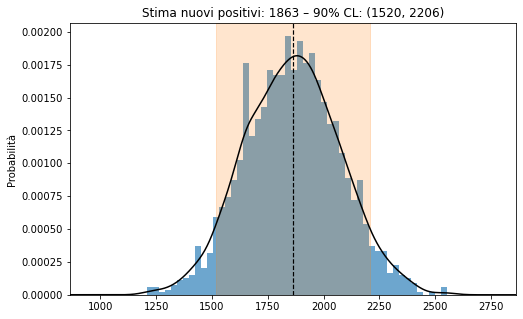

In [20]:
model = load_model('best_lstm_model.hdf5')

predict = []
for i in progressbar(range(0, N), "Computing: "):
    tomorrow = model.predict(X_tomorrow)
    predict.append(sc.inverse_transform(tomorrow))
    
predict = np.array(predict)
predict_df = pd.DataFrame(data={'predizioni': predict.flatten()})

fig, ax = plt.subplots(figsize=(8,5))
predict_df.plot.hist(ax=ax, density=True, bins=50, color='tab:blue', alpha=0.65, legend=False)
predict_df.plot.kde(ax=ax, legend=False, c='k')
ax.axvspan(predict_df.quantile(0.5 - cl/2)[0], predict_df.quantile(0.5 + cl/2)[0],
           color='tab:orange', alpha=0.2)
ax.axvline(predict_df.median()[0], c='k', ls='--', lw=1.2)

ax.set_xlim(predict_df.median()[0] - 1000, predict_df.median()[0] + 1000)
ax.set_ylabel('Probabilità')
plt.title(f'Stima nuovi positivi: {int(round(predict_df.median()[0],0))} – {int(round(100*cl,0))}% CL: ({int(round(predict_df.quantile(0.5 - cl/2)[0],0))}, {int(round(predict_df.quantile(0.5 + cl/2)[0],0))})')

fig.savefig(f'predizione_lstm_{N}_predict.png', dpi=300, bbox_inches='tight', facecolor='white');

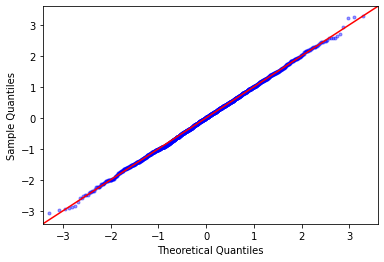

In [21]:
# Q-Q plot (with standardised values)
z = (predict - predict.mean()) / predict.std()
fig = sm.qqplot(z.flatten(), line='45', marker='.', alpha=0.4)
plt.show()

In [22]:
from statsmodels.stats.stattools import robust_kurtosis, robust_skewness

print(f'Excess kurtosis:{round(robust_kurtosis(predict)[0],4)}')
print(f'Excess skewness:{round(np.float64(robust_skewness(predict)[0][0][0]),4)}')

Excess kurtosis:-0.1116
Excess skewness:0.0303


In [23]:
cl = [0.68, 0.9, 0.95, 0.997]

print(f'An estimate for tomorrow is: {int(round(predict.mean(),0))} ± {int(round(predict.std(),0))} (STD)')
print(f'A robust one is: {int(round(np.median(predict),0))} ± {int(round(mad(predict),0))} (MAD)\n')

for i in cl:
    lower_lim = np.quantile(predict, 0.5 - i/2)
    upper_lim = np.quantile(predict, 0.5 + i/2)
    print(f'{100*i}% CL: ({int(round(lower_lim,0))}, {int(round(upper_lim,0))})')

An estimate for tomorrow is: 1861 ± 212 (STD)
A robust one is: 1863 ± 145 (MAD)

68.0% CL: (1647, 2071)
90.0% CL: (1520, 2206)
95.0% CL: (1443, 2276)
99.7% CL: (1242, 2482)


## GRU layers

In [25]:
# Input
inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))

# 1st hidden layer
x = keras.layers.GRU(60, return_sequences=True)(inputs)
x = keras.layers.Dropout(0.2)(x, training=True)

# 2nd hidden layer
x = keras.layers.GRU(50)(x)
x = keras.layers.Dropout(0.2)(x, training=True)

# Output
outputs = keras.layers.Dense(1, activation='linear')(x)

model_gru = keras.Model(inputs=inputs, outputs=outputs)
model_gru.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='best_gru_model.hdf5',
                                                            save_best_only=True, monitor='val_loss',
                                                            mode='auto', verbose=1)

In [26]:
history = model_gru.fit(X, y, epochs = 100, batch_size = 16, validation_split = 0.15, shuffle=False,
                        callbacks=[early_stopping_monitor, model_checkpoint_callback])

Epoch 1/100
23/23 [==============================] - 7s 57ms/step - loss: 0.0224 - val_loss: 0.1236

Epoch 00001: val_loss improved from inf to 0.12363, saving model to best_gru_model.hdf5
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0539

Epoch 00002: val_loss improved from 0.12363 to 0.05391, saving model to best_gru_model.hdf5
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0227 - val_loss: 0.0339

Epoch 00003: val_loss improved from 0.05391 to 0.03386, saving model to best_gru_model.hdf5
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0230

Epoch 00004: val_loss improved from 0.03386 to 0.02297, saving model to best_gru_model.hdf5
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0153

Epoch 00005: val_loss improved from 0.02297 to 0.01529, saving model to best_gru_model.hdf5
Epoch 6/100
23/23 [========================

23/23 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0117

Epoch 00052: val_loss did not improve from 0.00840
Epoch 53/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0081

Epoch 00053: val_loss improved from 0.00840 to 0.00805, saving model to best_gru_model.hdf5
Epoch 54/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0084

Epoch 00054: val_loss did not improve from 0.00805
Epoch 55/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0126

Epoch 00055: val_loss did not improve from 0.00805
Epoch 56/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0094

Epoch 00056: val_loss did not improve from 0.00805
Epoch 57/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0101

Epoch 00057: val_loss did not improve from 0.00805
Epoch 58/100
23/23 [==============================] - 0s 7ms

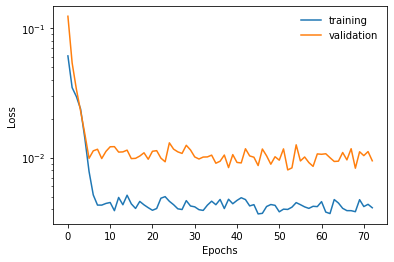

In [27]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.yscale('log')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [28]:
predict = model_gru.predict(X)
predict = sc.inverse_transform(predict)

predicted_gru = []
for i in predict:
    predicted_gru.append(i[0])

In [29]:
predicted_gru_df = campania[1:][['data']]
predicted_gru_df['predizioni'] = predicted_gru
predicted_gru_df['dati DPC'] = campania.nuovi_positivi
predicted_gru_df[-30:].describe()

,predizioni,dati DPC
count,30.000000,30.000000
mean,1792.354106,1820.700000
std,405.466857,378.289449
min,914.664917,846.000000
25%,1624.073669,1665.500000
50%,1792.681458,1910.000000
75%,2070.021057,2046.750000
max,2625.343262,2314.000000


In [30]:
residuals = predicted_gru_df['predizioni'] - predicted_gru_df['dati DPC']
residuals.median()

65.4471549987793

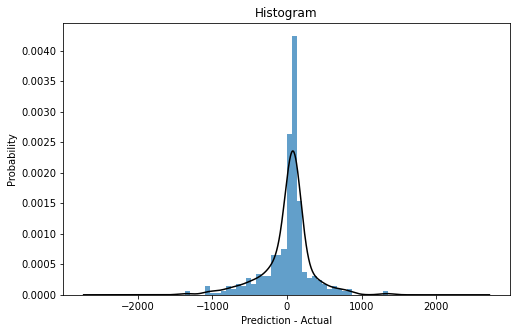

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
residuals.plot.hist(ax=ax, density=True, bins=40, color='tab:blue', alpha=0.7)
residuals.plot.kde(ax=ax, legend=False, title='Histogram', c='k')
ax.set_ylabel('Probability')
ax.set_xlabel('Prediction - Actual');

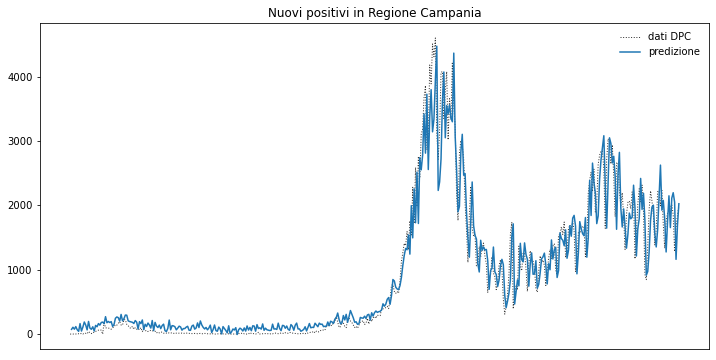

In [32]:
plt.figure(figsize=(12,6))
plt.plot(campania.data, campania.nuovi_positivi, 'k', ls=':', lw=1, alpha=0.8, label='dati DPC')
plt.plot(predicted_gru_df.data, predicted_gru_df.predizioni, 'tab:blue', label='predizione')
plt.xticks([])

plt.legend(frameon=False)
plt.title('Nuovi positivi in Regione Campania')
#plt.savefig('GRU_fit.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [33]:
# Confidence Level and number of iterations (better not to go below 1000)
cl = 0.9
N = 2000

In [34]:
last = campania.nuovi_positivi.values[-1]
last_sc = sc.transform(last.reshape(-1, 1))
X_tomorrow = np.reshape(last_sc, (last_sc.shape[0], last_sc.shape[1], 1))

Computing: [##################################################] 100%


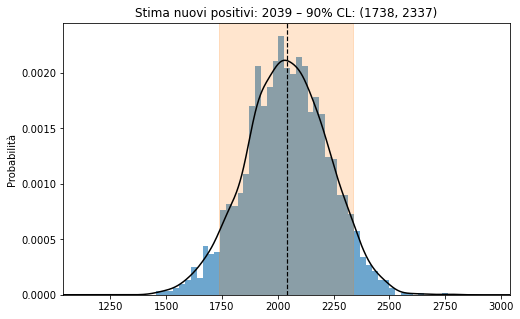

In [35]:
model = load_model('best_gru_model.hdf5')

predict_gru = []
for i in progressbar(range(0, N), "Computing: "):
    tomorrow = model.predict(X_tomorrow)
    predict_gru.append(sc.inverse_transform(tomorrow))
    
predict_gru = np.array(predict_gru)
predict_gru_df = pd.DataFrame(data={'predizioni': predict_gru.flatten()})

fig, ax = plt.subplots(figsize=(8,5))
predict_gru_df.plot.hist(ax=ax, density=True, bins=50, color='tab:blue', alpha=0.65, legend=False)
predict_gru_df.plot.kde(ax=ax, legend=False, c='k')
ax.axvspan(predict_gru_df.quantile(0.5 - cl/2)[0], predict_gru_df.quantile(0.5 + cl/2)[0],
           color='tab:orange', alpha=0.2)
ax.axvline(predict_gru_df.median()[0], c='k', ls='--', lw=1.2)

ax.set_xlim(predict_gru_df.median()[0] - 1000, predict_gru_df.median()[0] + 1000)
ax.set_ylabel('Probabilità')
plt.title(f'Stima nuovi positivi: {int(round(predict_gru_df.median()[0],0))} – {int(round(100*cl,0))}% CL: ({int(round(predict_gru_df.quantile(0.5 - cl/2)[0],0))}, {int(round(predict_gru_df.quantile(0.5 + cl/2)[0],0))})')

fig.savefig(f'predizione_gru_{N}_predict.png', dpi=300, bbox_inches='tight', facecolor='white');

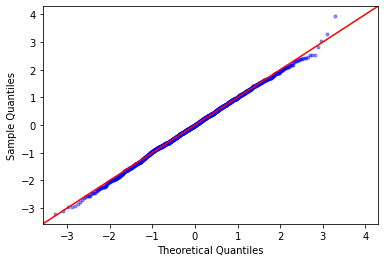

In [36]:
# Q-Q plot (with standardised values)
z_gru = (predict_gru - predict_gru.mean()) / predict_gru.std()
fig = sm.qqplot(z_gru.flatten(), line='45', marker='.', alpha=0.4)
plt.show()

In [37]:
print(f'Excess kurtosis:{round(robust_kurtosis(predict_gru)[0],4)}')
print(f'Excess skewness:{round(np.float64(robust_skewness(predict_gru)[0][0][0]),4)}')

Excess kurtosis:-0.0234
Excess skewness:-0.0622


In [38]:
cl = [0.68, 0.9, 0.95, 0.997]

print(f'An estimate for tomorrow is: {int(round(predict_gru.mean(),0))} ± {int(round(predict_gru.std(),0))} (STD)')
print(f'A robust one is: {int(round(np.median(predict_gru),0))} ± {int(round(mad(predict_gru),0))} (MAD)\n')

for i in cl:
    lower_lim = np.quantile(predict_gru, 0.5 - i/2)
    upper_lim = np.quantile(predict_gru, 0.5 + i/2)
    print(f'{100*i}% CL: ({int(round(lower_lim,0))}, {int(round(upper_lim,0))})')

An estimate for tomorrow is: 2041 ± 183 (STD)
A robust one is: 2039 ± 124 (MAD)

68.0% CL: (1866, 2223)
90.0% CL: (1738, 2337)
95.0% CL: (1676, 2387)
99.7% CL: (1501, 2555)


## Multivariate forecasting (Under construction)
### Model using ```nuovi_positivi``` + ```incremento_tamponi```

In [ ]:
#campania.isna().sum()

In [ ]:
train_2 = campania.iloc[:,[8,-1]].values
sc_2 = MinMaxScaler(feature_range = (0, 1))
train_2_sc = sc_2.fit_transform(train_2)

In [ ]:
#train_2_sc

In [ ]:
X, y = [], []

for i in range(1, len(campania)):
    X.append(train_2_sc[i-1:i])
    y.append(train_2_sc[i,0])

X, y = np.asarray(X), np.asarray(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 2))
X.shape, y.shape

In [ ]:
inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))

# 1° hidden layer
x = keras.layers.LSTM(100, return_sequences=True)(inputs)
x = keras.layers.Dropout(0.2)(x)#, training=True)  #(prova L2)

# 2° hidden layer
x = keras.layers.LSTM(80)(x)
x = keras.layers.Dropout(0.2)(x)#, training=True)

# uscita
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# callbacks
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='best_lstm_model_2_feat.hdf5',
                                                            save_best_only=True, monitor='val_loss',
                                                            mode='auto', verbose=1)


#model.summary()

In [ ]:
history = model.fit(X, y, epochs = 100, batch_size = 21, validation_split = 0.15, shuffle=False,
                    callbacks=[early_stopping_monitor, model_checkpoint_callback])

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')

plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

plt.show()

In [ ]:
predict = model.predict(X)
predict = sc_2.inverse_transform(predict + [0,0])

test_predicted = []
for i in predict:
  test_predicted.append(i[0])

predicted_df = campania[1:][['data']]
predicted_df['predizioni'] = test_predicted
predicted_df['dati DPC'] = campania.nuovi_positivi
predicted_df

In [ ]:
errors = predicted_df['predizioni'] - predicted_df['dati DPC']
errors.median()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
errors.plot.hist(ax=ax, density=True, bins=40, color='tab:blue', alpha=0.7)
errors.plot.kde(ax=ax, legend=False, title='Histogram', c='k')
ax.set_ylabel('Probability')
ax.set_xlabel('Prediction - Actual');

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(campania.data, campania.nuovi_positivi, 'k', ls=':', lw=1, alpha=0.8, label='dati DPC')
plt.plot(predicted_df.data, predicted_df.predizioni, 'tab:blue', label='predizione')
plt.xticks([])

plt.legend(frameon=False)
plt.title('Nuovi positivi in Regione Campania');
#plt.savefig('LSTM_fit.png', dpi=300, bbox_inches='tight', facecolor='white');

In [ ]:
ieri = campania.iloc[:,[8,-1]].values[-1]
ieri_sc = sc_2.transform(ieri.reshape(1,-1))

In [ ]:
X_domani = []
X_domani.append(ieri_sc)
X_domani = np.array(X_domani)
X_domani = np.reshape(X_domani, (X_domani.shape[0], X_domani.shape[1], 2))

In [ ]:
# scaler remembers that I passed it a 2D input with two columns, and works under the assumption that
# all subsequent data passed to it will have the same number of features/columns. So I need to pass
# inverse_transform an input with the same number of columns (I add zeroes)

domani = model.predict(X_domani)
domani = sc_2.inverse_transform(domani+[0,0])
int(domani[0][0])